# Wave Data Feature Reference

## Primary Swell (SW1)
| Variable | Description | Units |
|----------|-------------|-------|
| `VMDR_SW1` | Sea surface primary swell wave from direction | ° |
| `VTM01_SW1` | Sea surface primary swell wave mean period | s |
| `VHM0_SW1` | Sea surface primary swell wave significant height | m |

## Secondary Swell (SW2)
| Variable | Description | Units |
|----------|-------------|-------|
| `VMDR_SW2` | Sea surface secondary swell wave from direction | ° |
| `VTM01_SW2` | Sea surface secondary swell wave mean period | s |
| `VHM0_SW2` | Sea surface secondary swell wave significant height | m |

## Combined Wave Properties
| Variable | Description | Units |
|----------|-------------|-------|
| `VMDR` | Sea surface wave from direction | ° |
| `VPED` | Sea surface wave from direction at variance spectral density maximum | ° |
| `VTM10` | Sea surface wave mean period from variance spectral density inverse frequency moment | s |
| `VTM02` | Sea surface wave mean period from variance spectral density second frequency moment | s |
| `VTPK` | Sea surface wave period at variance spectral density maximum | s |
| `VHM0` | Sea surface wave significant height | m |

## Stokes Drift
| Variable | Description | Units |
|----------|-------------|-------|
| `VSDX` | Sea surface wave stokes drift x velocity | m/s |
| `VSDY` | Sea surface wave stokes drift y velocity | m/s |

## Wind Waves (WW)
| Variable | Description | Units |
|----------|-------------|-------|
| `VMDR_WW` | Sea surface wind wave from direction | ° |
| `VTM01_WW` | Sea surface wind wave mean period | s |
| `VHM0_WW` | Sea surface wind wave significant height | m |

## Notes
- **VHM0**: Significant wave height (Hs) - average height of the highest 1/3 of waves
- **Direction variables**: Direction waves are coming FROM (meteorological convention)
- **Swell vs Wind Waves**: Swell (SW1/SW2) are long-period waves from distant storms, Wind Waves (WW) are locally generated
- **Spectral moments**: VTM02 and VTM10 represent different statistical measures of the wave period distribution
- **Stokes Drift**: Net forward motion of water particles due to wave action

In [1]:
# Cell 1 - Environment setup (put this first)
from dotenv import load_dotenv
import os
from pathlib import Path
import xarray as xr


# Load environment variables from .env file
load_dotenv()

# Get paths from environment
print(os.getenv('WAVE_DATA_DIR'))
DATA_DIR = os.getenv('WAVE_DATA_DIR')
# Create directories if they don't exist


print(f"✓ Raw data directory: {DATA_DIR}")

python-dotenv could not parse statement starting at line 2
python-dotenv could not parse statement starting at line 9


C:\Development\GitHub\wave-energy-forecasting-ai\data
✓ Raw data directory: C:\Development\GitHub\wave-energy-forecasting-ai\data


In [ ]:
# For AI wave prediction model using Copernicus Marine data

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import copernicusmarine
import os



# Step 1: Load wave data directly into xarray
print("Loading wave data from Copernicus Marine...")
print("This may take 2-3 minutes for initial download...")

# Washington/BC offshore high wave activity region
# USE : 'copernicusmarine login' to set up credentials first before running this code
ds = copernicusmarine.open_dataset(
    dataset_id="cmems_mod_glo_wav_my_0.2deg_PT3H-i",
    minimum_longitude=-130.0,
    maximum_longitude=-124.0,
    minimum_latitude=46.0,
    maximum_latitude=50.5,
    start_datetime="2020-01-01T00:00:00",
    end_datetime="2023-04-30T21:00:00"
)

c:\Development\GitHub\wave-energy-forecasting-ai\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading wave data from Copernicus Marine...
This may take 2-3 minutes for initial download...


INFO - 2025-09-01T22:29:40Z - Selected dataset version: "202411"
INFO - 2025-09-01T22:29:40Z - Selected dataset part: "default"


In [3]:
# Step 2: Check dataset info
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(f"Dataset dimensions: {ds.dims}")
print(f"Dataset size: {ds.nbytes / 1e9:.2f} GB")
print(f"Variables: {list(ds.data_vars.keys())}")
print(f"Time range: {ds.time.min().values} to {ds.time.max().values}")

# Step 3: Load into memory (one-time download)
print("\nLoading all data into memory for fast processing...")
ds = ds.load()
print("✓ Data loaded successfully!")



DATASET OVERVIEW
Dataset dimensions: FrozenMappingWarningOnValuesAccess({'time': 9728, 'latitude': 23, 'longitude': 31})
Dataset size: 0.94 GB
Variables: ['VHM0', 'VHM0_SW1', 'VHM0_SW2', 'VHM0_WW', 'VMDR', 'VMDR_SW1', 'VMDR_SW2', 'VMDR_WW', 'VPED', 'VSDX', 'VSDY', 'VTM01_SW1', 'VTM01_SW2', 'VTM01_WW', 'VTM02', 'VTM10', 'VTPK']
Time range: 2020-01-01T00:00:00.000000000 to 2023-04-30T21:00:00.000000000

Loading all data into memory for fast processing...
✓ Data loaded successfully!


In [4]:
# Step 4: Quick data quality assessment
print("\n" + "="*50)
print("DATA QUALITY CHECK")
print("="*50)

# Check missing values efficiently
missing_summary = {}
for var in ds.data_vars:
    total_points = ds[var].size
    missing_points = ds[var].isnull().sum().values
    missing_pct = (missing_points / total_points) * 100
    missing_summary[var] = missing_pct
    print(f"{var}: {missing_pct:.1f}% missing")

# Step 5: Basic data ranges
print("\nDATA RANGES:")
for var in ds.data_vars:
    min_val = ds[var].min().values
    max_val = ds[var].max().values
    print(f"{var}: [{min_val:.3f}, {max_val:.3f}]")

# Step 6: Apply basic cleaning
print("\n" + "="*50)
print("CLEANING DATA")
print("="*50)

# Remove obviously invalid values
ds_clean = ds.where(
    (ds['VHM0'] >= 0) & (ds['VHM0'] <= 25) &           # Reasonable total wave heights
    (ds['VHM0_SW1'] >= 0) & (ds['VHM0_SW1'] <= 20) &   # Reasonable swell heights
    (ds['VHM0_SW2'] >= 0) & (ds['VHM0_SW2'] <= 15) &   # Reasonable secondary swell
    (ds['VHM0_WW'] >= 0) & (ds['VHM0_WW'] <= 15) &     # Reasonable wind wave heights
    (ds['VTPK'] > 0) & (ds['VTPK'] <= 30) &            # Reasonable peak periods
    (ds['VMDR'] >= 0) & (ds['VMDR'] <= 360) &          # Valid directions
    (ds['VMDR_SW1'] >= 0) & (ds['VMDR_SW1'] <= 360) &  # Valid swell directions
    (ds['VMDR_SW2'] >= 0) & (ds['VMDR_SW2'] <= 360) &  # Valid swell directions
    (ds['VMDR_WW'] >= 0) & (ds['VMDR_WW'] <= 360)      # Valid wind wave directions
)

print("✓ Basic cleaning applied")


DATA QUALITY CHECK
VHM0: 15.3% missing
VHM0_SW1: 15.3% missing
VHM0_SW2: 15.3% missing
VHM0_WW: 15.3% missing
VMDR: 15.3% missing
VMDR_SW1: 15.3% missing
VMDR_SW2: 15.3% missing
VMDR_WW: 15.3% missing
VPED: 15.3% missing
VSDX: 15.3% missing
VSDY: 15.3% missing
VTM01_SW1: 15.3% missing
VTM01_SW2: 15.3% missing
VTM01_WW: 15.3% missing
VTM02: 15.3% missing
VTM10: 15.3% missing
VTPK: 15.3% missing

DATA RANGES:
VHM0: [0.000, 11.480]
VHM0_SW1: [0.000, 8.230]
VHM0_SW2: [0.000, 4.830]
VHM0_WW: [0.000, 11.230]
VMDR: [0.000, 360.000]
VMDR_SW1: [0.000, 360.000]
VMDR_SW2: [0.000, 360.000]
VMDR_WW: [0.000, 360.000]
VPED: [7.500, 352.500]
VSDX: [-0.370, 0.380]
VSDY: [-0.390, 0.390]
VTM01_SW1: [1.400, 26.890]
VTM01_SW2: [0.000, 28.570]
VTM01_WW: [0.000, 12.240]
VTM02: [1.360, 14.710]
VTM10: [1.550, 24.250]
VTPK: [1.800, 28.570]

CLEANING DATA
✓ Basic cleaning applied



Generating validation plot...


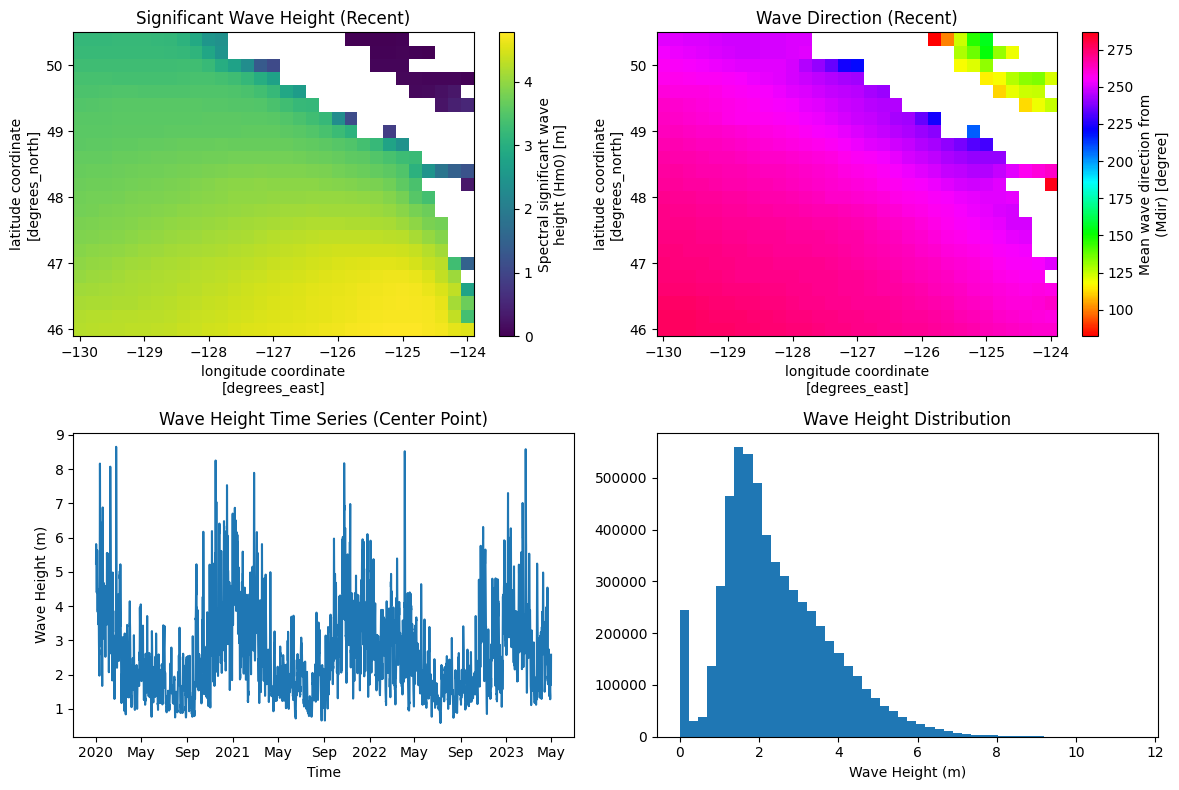

In [5]:
# Step 7: Quick validation plot
print("\nGenerating validation plot...")
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot 1: Significant wave height map (recent time)
ds_clean['VHM0'].isel(time=-100).plot(ax=axes[0,0], cmap='viridis')
axes[0,0].set_title('Significant Wave Height (Recent)')

# Plot 2: Wave direction map
ds_clean['VMDR'].isel(time=-100).plot(ax=axes[0,1], cmap='hsv')
axes[0,1].set_title('Wave Direction (Recent)')

# Plot 3: Time series at center point
center_lat = ds_clean.latitude.values[len(ds_clean.latitude)//2]
center_lon = ds_clean.longitude.values[len(ds_clean.longitude)//2]
point_data = ds_clean.sel(latitude=center_lat, longitude=center_lon, method='nearest')
point_data['VHM0'].plot(ax=axes[1,0])
axes[1,0].set_title('Wave Height Time Series (Center Point)')
axes[1,0].set_ylabel('Wave Height (m)')

# Plot 4: Wave height histogram
ds_clean['VHM0'].plot.hist(bins=50, ax=axes[1,1])
axes[1,1].set_title('Wave Height Distribution')
axes[1,1].set_xlabel('Wave Height (m)')

plt.tight_layout()
plt.show()

Total grid points: 713
Ocean points: 604 (84.7%)
Land points: 109 (15.3%)


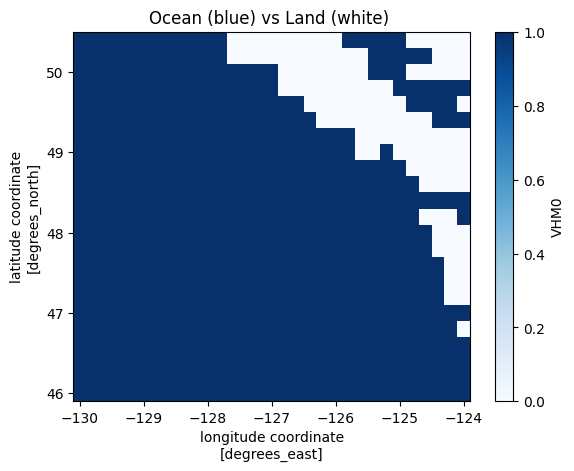

In [6]:
#Lets see how much of our domain is actually ocean
ocean_mask = ~ds_clean['VHM0'].isel(time=0).isnull()
total_points = ocean_mask.size
ocean_points = ocean_mask.sum().values
land_points = total_points - ocean_points

print(f"Total grid points: {total_points}")
print(f"Ocean points: {ocean_points} ({ocean_points/total_points*100:.1f}%)")
print(f"Land points: {land_points} ({land_points/total_points*100:.1f}%)")

# Visualize the land/ocean mask
ocean_mask.plot(cmap='Blues')
plt.title('Ocean (blue) vs Land (white) ')
plt.show()

In [7]:
# Step 8: Final summary
print("\n" + "="*50)
print("FINAL DATASET SUMMARY")
print("="*50)
print(f"Clean dataset shape: {ds_clean.dims}")
print(f"Time span: {(ds_clean.time.max() - ds_clean.time.min()).values}")
print(f"Spatial coverage: {ds_clean.latitude.min().values:.2f}°N to {ds_clean.latitude.max().values:.2f}°N")
print(f"                  {ds_clean.longitude.min().values:.2f}°W to {ds_clean.longitude.max().values:.2f}°W")

overall_missing = np.mean(list(missing_summary.values()))
print(f"Average missing data: {overall_missing:.1f}%")
print("\n✓ Dataset ready for AI model development!")




FINAL DATASET SUMMARY
Clean dataset shape: FrozenMappingWarningOnValuesAccess({'time': 9728, 'latitude': 23, 'longitude': 31})
Time span: 105051600000000000 nanoseconds
Spatial coverage: 46.00°N to 50.40°N
                  -130.00°W to -124.00°W
Average missing data: 15.3%

✓ Dataset ready for AI model development!


In [11]:
# Save cleaned dataset for future use
ds_clean.to_netcdf(Path(DATA_DIR) / 'processed' / 'cleaned_wave_data.nc')
print(f"✓ Cleaned dataset saved to {Path(DATA_DIR) / 'processed' / 'cleaned_wave_data.nc'}")

✓ Cleaned dataset saved to C:\Development\GitHub\wave-energy-forecasting-ai\data\processed\cleaned_wave_data.nc
